# Game Scene Composition with Image Inpainting
==========================================

This notebook demonstrates how to create a composite game scene by placing
game elements (building, NPC, vehicle) on a background using image inpainting.
We'll use masks to define where each element should be placed and use
inpainting to seamlessly integrate them into the scene.

## Import the necessary libraries

In [21]:
!pip install torch torchvision "numpy<2.0.0" matplotlib pillow requests diffusers transformers accelerate safetensors

In [22]:
# Core imports
import torch
import numpy as np
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt

# Image processing
from PIL import Image, ImageDraw, ImageOps, ImageFilter
import requests

# Diffusion models
from diffusers import (
    StableDiffusionInpaintPipeline,
    AutoPipelineForInpainting
)

## Device Setup

In [23]:
def setup_device():
    """Setup optimal device for diffusion models."""
    if torch.cuda.is_available():
        return "cuda", torch.float16
    elif torch.backends.mps.is_available():
        return "mps", torch.float32
    else:
        return "cpu", torch.float32

# Setup device
device, dtype = setup_device()
print(f"Using device: {device} with dtype: {dtype}")

Using device: mps with dtype: torch.float32


## Load Inpainting Pipeline

In [24]:
def load_inpainting_pipeline(device="cuda", dtype=torch.float16):
    """Load inpainting pipeline with alternative model."""
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "Lykon/dreamshaper-8-inpainting",
        torch_dtype=dtype,
        safety_checker=None,
        requires_safety_checker=False
    )
    pipe = pipe.to(device)
    
    if hasattr(pipe, 'enable_attention_slicing'):
        pipe.enable_attention_slicing()
    return pipe

# Load pipeline
pipe = load_inpainting_pipeline(device, dtype)
print("Inpainting pipeline loaded successfully!")

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 18.11it/s]


Inpainting pipeline loaded successfully!


## Image Loading and Processing Functions

Loading game assets...


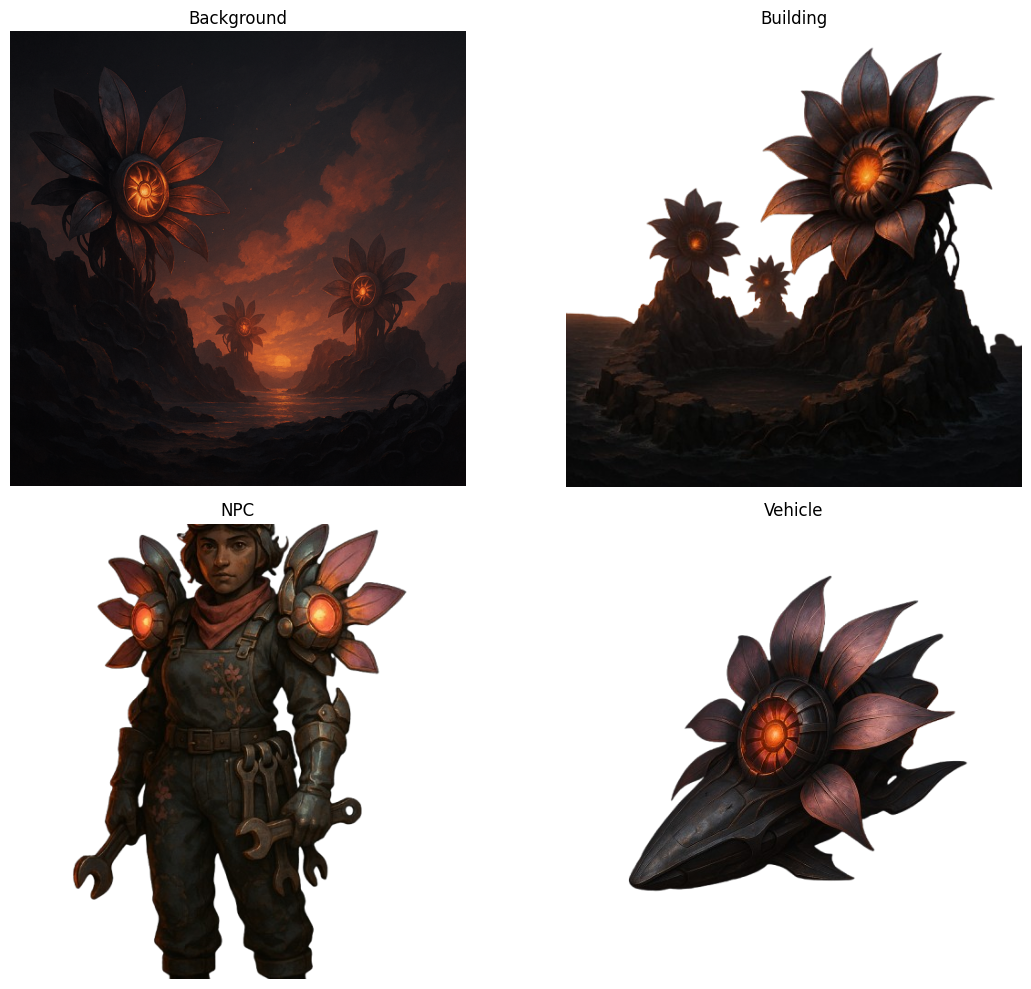

In [25]:
def load_image_from_path(path: str) -> Image.Image:
    """Load an image from a local file path."""
    try:
        image = Image.open(path)
        return image
    except Exception as e:
        print(f"Error loading image from path: {e}")
        raise

def resize_image_maintain_aspect(image: Image.Image, target_size: Tuple[int, int]) -> Image.Image:
    """Resize image while maintaining aspect ratio and padding if necessary."""
    target_width, target_height = target_size
    img_width, img_height = image.size
    
    # Calculate scaling factor to fit within target size
    scale = min(target_width / img_width, target_height / img_height)
    new_width = int(img_width * scale)
    new_height = int(img_height * scale)
    
    # Resize image
    resized = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create new image with target size and paste resized image in center
    result = Image.new('RGBA', target_size, (0, 0, 0, 0))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    result.paste(resized, (paste_x, paste_y))
    
    return result

# Load and display our game assets
print("Loading game assets...")
background = load_image_from_path("assets/background.png")
building = load_image_from_path("assets/building2.png")
npc = load_image_from_path("assets/npc.png")
vehicle = load_image_from_path("assets/vehicle.png")

# Display the assets
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].imshow(background)
axes[0, 0].set_title("Background")
axes[0, 0].axis('off')

axes[0, 1].imshow(building)
axes[0, 1].set_title("Building")
axes[0, 1].axis('off')

axes[1, 0].imshow(npc)
axes[1, 0].set_title("NPC")
axes[1, 0].axis('off')

axes[1, 1].imshow(vehicle)
axes[1, 1].set_title("Vehicle")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Mask Creation Functions

In [26]:
def create_rectangular_mask(image: Image.Image, bbox: Tuple[int, int, int, int]) -> Image.Image:
    """Create a rectangular mask for inpainting."""
    mask = Image.new("L", image.size, 0)
    draw = ImageDraw.Draw(mask)
    draw.rectangle(bbox, fill=255)
    return mask

def create_element_mask(image: Image.Image, element_bbox: Tuple[int, int, int, int], 
                       feather_radius: int = 10) -> Image.Image:
    """Create a feathered mask for smooth element integration."""
    mask = create_rectangular_mask(image, element_bbox)
    
    # Apply feathering for smooth edges
    if feather_radius > 0:
        # Create a slightly larger mask and blur it
        expanded_mask = Image.new("L", image.size, 0)
        draw = ImageDraw.Draw(expanded_mask)
        left, top, right, bottom = element_bbox
        expanded_bbox = (left - feather_radius, top - feather_radius, 
                        right + feather_radius, bottom + feather_radius)
        draw.rectangle(expanded_bbox, fill=255)
        
        # Blur the expanded mask
        blurred_mask = expanded_mask.filter(ImageFilter.GaussianBlur(radius=feather_radius))
        
        # Threshold to get back to binary but with smooth edges
        blurred_array = np.array(blurred_mask)
        thresholded = (blurred_array > 128).astype(np.uint8) * 255
        mask = Image.fromarray(thresholded)
    
    return mask

## Composite Scene Creation

Creating composite scene...


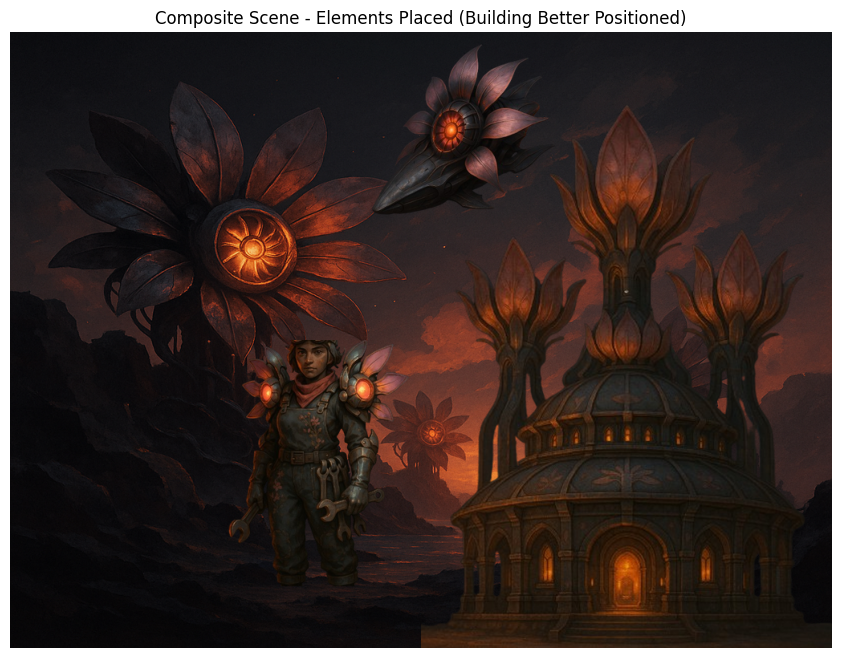

In [27]:
def create_composite_scene(background_path: str, building_path: str, 
                          npc_path: str, vehicle_path: str, 
                          target_size: Tuple[int, int] = (1024, 768)):
    """Create a composite scene by placing elements on the background."""
    
    # Load all images
    background = load_image_from_path(background_path)
    building = load_image_from_path(building_path)
    npc = load_image_from_path(npc_path)
    vehicle = load_image_from_path(vehicle_path)
    
    # Resize background to target size
    background = background.resize(target_size, Image.Resampling.LANCZOS)
    
    # Define positions for elements (adjust these based on your scene)
    # These are relative positions that will be scaled to the target size
    # Building: Better positioned for natural integration
    building_bbox = (int(target_size[0] * 0.5), int(target_size[1] * -0.1), 
                    int(target_size[0] * 1.0), int(target_size[1] * 1.2))
    npc_bbox = (int(target_size[0] * 0.20), int(target_size[1] * 0.5), 
                int(target_size[0] * 0.55), int(target_size[1] * 0.9))
    vehicle_bbox = (int(target_size[0] * 0.4), int(target_size[1] * -0.5), 
                   int(target_size[0] * 0.7), int(target_size[1] * 0.85))
    
    # Resize elements to fit their designated areas
    building_resized = resize_image_maintain_aspect(building, 
        (building_bbox[2] - building_bbox[0], building_bbox[3] - building_bbox[1]))
    npc_resized = resize_image_maintain_aspect(npc, 
        (npc_bbox[2] - npc_bbox[0], npc_bbox[3] - npc_bbox[1]))
    vehicle_resized = resize_image_maintain_aspect(vehicle, 
        (vehicle_bbox[2] - vehicle_bbox[0], vehicle_bbox[3] - vehicle_bbox[1]))
    
    # Create composite image
    composite = background.copy()
    
    # Paste elements with alpha blending
    composite.paste(building_resized, (building_bbox[0], building_bbox[1]), building_resized)
    composite.paste(npc_resized, (npc_bbox[0], npc_bbox[1]), npc_resized)
    composite.paste(vehicle_resized, (vehicle_bbox[0], vehicle_bbox[1]), vehicle_resized)
    
    return composite, building_bbox, npc_bbox, vehicle_bbox

# Create the composite scene
print("Creating composite scene...")
composite, building_bbox, npc_bbox, vehicle_bbox = create_composite_scene(
    "assets/background.png",
    "assets/building.png", 
    "assets/npc.png",
    "assets/vehicle.png"
)

# Display the composite
plt.figure(figsize=(12, 8))
plt.imshow(composite)
plt.title("Composite Scene - Elements Placed (Building Better Positioned)")
plt.axis('off')
plt.show()

## Visualization of Composition Steps

In [28]:
# Install all required dependencies for the image inpainting notebook
# Run this cell first to ensure all libraries are available

import subprocess
import sys

def install_package(package):
    """Install a package using pip."""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError:
        print(f"✗ Failed to install {package}")

# Core dependencies
print("Installing core dependencies...")
core_packages = [
    "torch",                    # PyTorch for deep learning
    "torchvision",             # Computer vision utilities for PyTorch
    "numpy",                   # Numerical computing
    "matplotlib",              # Plotting and visualization
    "pillow",                  # Image processing (PIL)
    "requests",                # HTTP library for downloading
]

# AI/ML specific dependencies
print("\nInstalling AI/ML dependencies...")
ai_packages = [
    "diffusers",               # Hugging Face diffusion models
    "transformers",            # Hugging Face transformers library
    "accelerate",              # Accelerated training and inference
]

# Optional but recommended for better performance (removed xformers due to build issues)
print("\nInstalling optional performance packages...")
optional_packages = [
    "safetensors",             # Safe tensor serialization
]

# Install all packages
all_packages = core_packages + ai_packages + optional_packages

print("Starting installation...")
for package in all_packages:
    install_package(package)

print("\n" + "="*50)
print("INSTALLATION COMPLETE!")
print("="*50)
print("\nAll required packages have been installed:")
print("\nCore packages:")
for pkg in core_packages:
    print(f"  - {pkg}")
print("\nAI/ML packages:")
for pkg in ai_packages:
    print(f"  - {pkg}")
print("\nOptional packages:")
for pkg in optional_packages:
    print(f"  - {pkg}")

print("\nYou can now run the rest of the notebook!")
print("\nNote: If you're using a GPU, make sure you have CUDA installed.")
print("For Apple Silicon Macs, PyTorch will automatically use MPS.")
print("For other systems, PyTorch will fall back to CPU.")
print("\nNote: xformers was skipped due to build issues - this is optional and won't affect functionality.")

Installing core dependencies...

Installing AI/ML dependencies...

Installing optional performance packages...
Starting installation...


✓ Successfully installed torch
✓ Successfully installed torchvision
✓ Successfully installed numpy
✓ Successfully installed matplotlib
✓ Successfully installed pillow
✓ Successfully installed requests
✓ Successfully installed diffusers
✓ Successfully installed transformers
✓ Successfully installed accelerate
✓ Successfully installed safetensors

INSTALLATION COMPLETE!

All required packages have been installed:

Core packages:
  - torch
  - torchvision
  - numpy
  - matplotlib
  - pillow
  - requests

AI/ML packages:
  - diffusers
  - transformers
  - accelerate

Optional packages:
  - safetensors

You can now run the rest of the notebook!

Note: If you're using a GPU, make sure you have CUDA installed.
For Apple Silicon Macs, PyTorch will automatically use MPS.
For other systems, PyTorch will fall back to CPU.

Note: xformers was skipped due to build issues - this is optional and won't affect functionality.


## Inpainting for Seamless Integration

Applying inpainting for seamless integration...


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


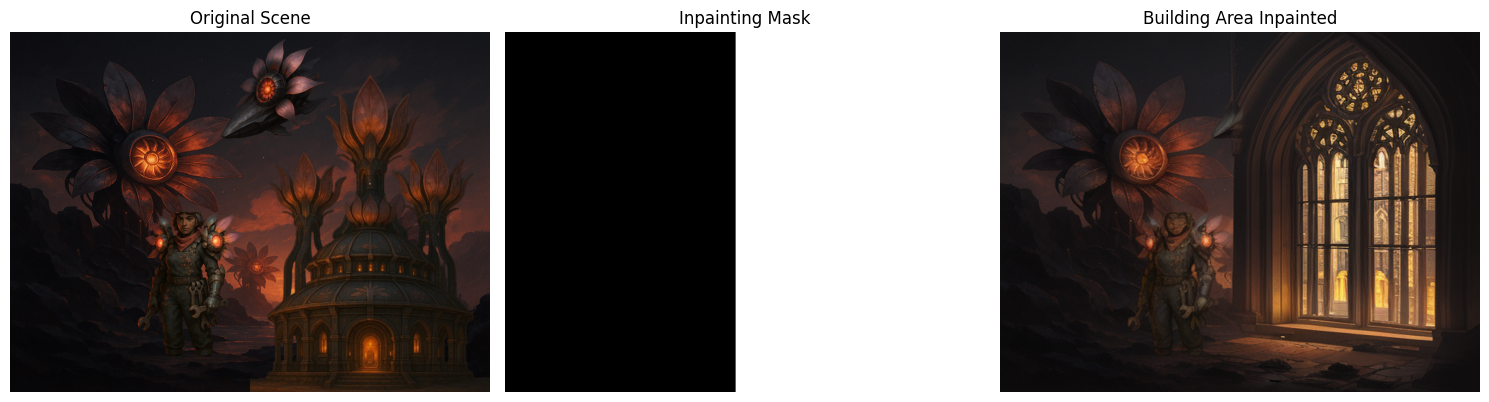

In [29]:
def inpaint_element(pipe, base_image: Image.Image, mask: Image.Image, 
                   prompt: str, seed: int = 42) -> Image.Image:
    """Fill masked regions based on text prompt for seamless integration."""
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    # Resize for processing
    process_size = (512, 512)
    image_resized = base_image.resize(process_size, Image.Resampling.LANCZOS)
    mask_resized = mask.resize(process_size, Image.Resampling.LANCZOS)
    
    with torch.no_grad():
        result = pipe(
            prompt=prompt,
            image=image_resized,
            mask_image=mask_resized,
            negative_prompt="blurry, low quality, distorted, artifacts",
            num_inference_steps=20,
            guidance_scale=7.5
        )
    
    # Resize result back to original size
    result_image = result.images[0].resize(base_image.size, Image.Resampling.LANCZOS)
    return result_image

def visualize_inpainting_results(original, mask, inpainted, title="Inpainting Result"):
    """Visualize inpainting before and after."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original)
    axes[0].set_title("Original Scene", fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Inpainting Mask", fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(inpainted)
    axes[2].set_title(title, fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Apply inpainting to improve integration
print("Applying inpainting for seamless integration...")

# Create mask around the building area for better integration
building_mask = create_element_mask(composite, building_bbox, feather_radius=20)

# Inpaint the building area for better integration
building_prompt = "ancient mystical building, steampunk architecture, glowing windows, detailed stonework, atmospheric lighting"
inpainted_building = inpaint_element(pipe, composite, building_mask, building_prompt, seed=123)

visualize_inpainting_results(composite, building_mask, inpainted_building, 
                            "Building Area Inpainted")

## Save Results

Results saved:
- composite_scene.png: Basic composite with elements placed
- final_scene_inpainted.png: Scene with inpainting applied for seamless integration


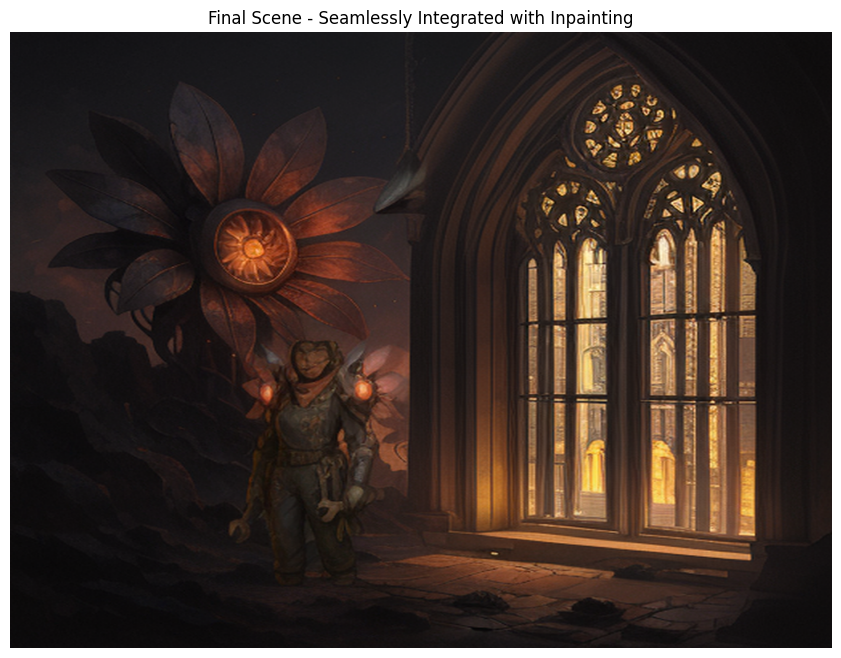

In [30]:
# Save the results
composite.save("composite_scene.png")
inpainted_building.save("final_scene_inpainted.png")

print("Results saved:")
print("- composite_scene.png: Basic composite with elements placed")
print("- final_scene_inpainted.png: Scene with inpainting applied for seamless integration")

# Display final result
plt.figure(figsize=(12, 8))
plt.imshow(inpainted_building)
plt.title("Final Scene - Seamlessly Integrated with Inpainting")
plt.axis('off')
plt.show()

## Experiment with Different Prompts

You can experiment with different prompts to achieve different effects:

100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


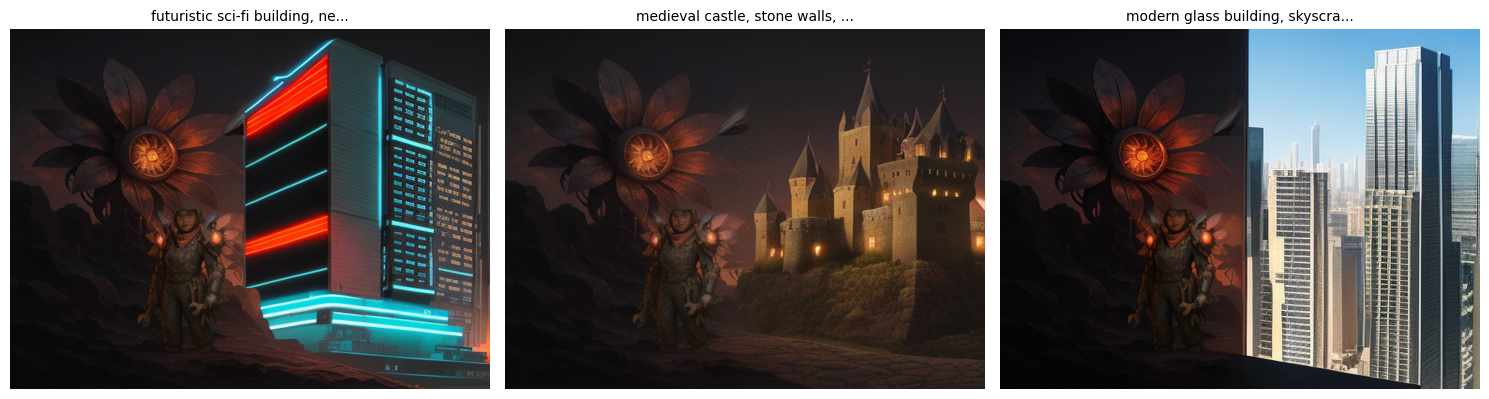

In [31]:
# Example: Try different prompts for the building area
different_prompts = [
    "futuristic sci-fi building, neon lights, metallic surfaces, cyberpunk style",
    "medieval castle, stone walls, towers, fantasy architecture",
    "modern glass building, skyscraper, urban architecture, cityscape"
]

fig, axes = plt.subplots(1, len(different_prompts), figsize=(15, 5))

for i, prompt in enumerate(different_prompts):
    result = inpaint_element(pipe, composite, building_mask, prompt, seed=100 + i)
    axes[i].imshow(result)
    axes[i].set_title(prompt[:30] + "...", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()